# **Load Dataset**

In [1]:
from tensorflow.keras.datasets import boston_housing

In [2]:
(train_data,train_label),(test_data,test_label) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [3]:
print("train_data : ",train_data.shape)
print("train_label : ",train_label.shape)
print("test_data : ",test_data.shape)
print("test_label : ",test_label.shape)

train_data :  (404, 13)
train_label :  (404,)
test_data :  (102, 13)
test_label :  (102,)


In [4]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [5]:
train_label[0]

15.2

# **Normalize the data**

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [7]:
train_data.shape[1]

13

# **Building Model**

In [8]:
import tensorflow as tf
def build_model():
  model = tf.keras.models.Sequential([tf.keras.layers.Dense(64, activation="relu",input_shape=(train_data.shape[1],)),
                                      tf.keras.layers.Dense(64,activation="relu"),
                                      tf.keras.layers.Dense(1)])
  model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
  return model

In [9]:
model = build_model()

In [13]:
val_data = train_data[:100]
x_train_data = train_data[100:]
val_label = train_label[:100]
y_train_label = train_label[100:]

In [14]:
model.fit(x_train_data,y_train_label,epochs=20,batch_size=1,validation_data=(val_data,val_label))

Epoch 1/20
304/304 [==============================] - 1s 3ms/step - loss: 7.9097 - mae: 1.8291 - val_loss: 2.2150 - val_mae: 0.9670
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 7.0057 - mae: 1.7170 - val_loss: 7.5032 - val_mae: 2.1203
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 6.8820 - mae: 1.7550 - val_loss: 3.5834 - val_mae: 1.3784
Epoch 4/20
304/304 [==============================] - 1s 4ms/step - loss: 6.4574 - mae: 1.6743 - val_loss: 3.7222 - val_mae: 1.3896
Epoch 5/20
304/304 [==============================] - 1s 2ms/step - loss: 6.1159 - mae: 1.6695 - val_loss: 4.2012 - val_mae: 1.4046
Epoch 6/20
304/304 [==============================] - 1s 2ms/step - loss: 6.1726 - mae: 1.6500 - val_loss: 8.2364 - val_mae: 2.1607
Epoch 7/20
304/304 [==============================] - 1s 2ms/step - loss: 5.6823 - mae: 1.6029 - val_loss: 4.3628 - val_mae: 1.4881
Epoch 8/20
304/304 [==============================] - 1s 2ms/step - loss: 5.

# **K-Fold Validation**

In [12]:
import numpy as np

k = 4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_label = train_label[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
  [train_data[:i * num_val_samples],
  train_data[(i + 1) * num_val_samples:]],
  axis=0)

  partial_train_label = np.concatenate(
  [train_label[:i * num_val_samples],
  train_label[(i + 1) * num_val_samples:]],
  axis=0)

  model = build_model()
  model.fit(partial_train_data, partial_train_label,
  epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_label, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
all_scores

[2.1881139278411865, 2.884908437728882, 2.637974739074707, 2.4547104835510254]

In [ ]:
np.mean(all_scores)

2.54142689704895

# **Saving The Validation logs at each fold**

In [15]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_label = train_label[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
  [train_data[:i * num_val_samples],
  train_data[(i + 1) * num_val_samples:]],
  axis=0)

  partial_train_label = np.concatenate(
  [train_label[:i * num_val_samples],
  train_label[(i + 1) * num_val_samples:]],
  axis=0)

  model = build_model()
  history = model.fit(partial_train_data, partial_train_label,
  validation_data=(val_data, val_label),
  epochs=num_epochs, batch_size=1, verbose=0)

  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


# ** Building the history of successive mean K-fold validation scores**

In [16]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

# **Plotting validation scores**

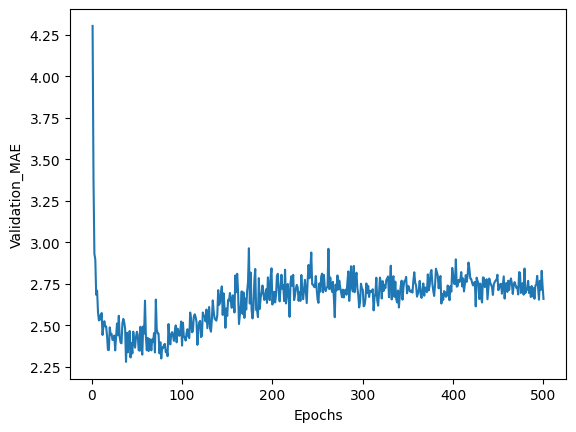

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1) , average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation_MAE")
plt.show()

# **Plotting validation scores, excluding the first 10 data points**

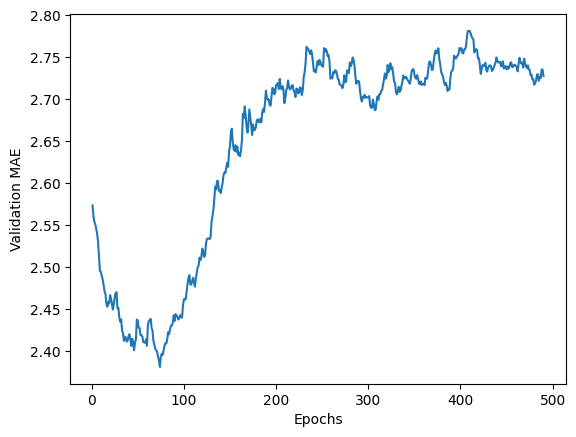

In [18]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


# **Training the final model**

In [19]:
model = build_model()
model.fit(train_data, train_label,epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_label)

4/4 [==============================] - 0s 4ms/step - loss: 16.2633 - mae: 2.6166


In [20]:
test_mae_score

2.616614580154419